<a href="https://colab.research.google.com/github/polo9800/vci-2/blob/main/LSTM_drought_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import glob

# Mount Google Drive (if files are stored there)
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your folder containing CSVs
folder_path = "/content/drive/My Drive/drought_prediction_project/vci"  # Update with your actual folder path

# Load and merge all CSV files
all_files = glob.glob(folder_path + "/*.csv")  # Get list of all CSV files
df_list = []  # Empty list to store dataframes

for file in all_files:
    df = pd.read_csv(file)  # Read CSV
    df_list.append(df)  # Add dataframe to list

# Combine all CSVs into one DataFrame
df = pd.concat(df_list, ignore_index=True)

# Convert date column to datetime format (modify if your column name is different)
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date (just in case)
df = df.sort_values(by='Date')

# Display first few rows
print(df.head())

# Save combined CSV
df.to_csv(folder_path + "/Combined_VCI_2000_2024.csv", index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


EmptyDataError: No columns to parse from file

the new code that combined all csv and with a debug since some years lacked data like 2024

In [ ]:
import pandas as pd
import glob
import os # Import os module for file checking

# Mount Google Drive (if files are stored there)
from google.colab import drive
drive.mount('/content/drive')

# Set the path to your folder containing CSVs
folder_path = "/content/drive/My Drive/drought_prediction_project/vci"  # Update with your actual folder path

# Load and merge all CSV files
all_files = glob.glob(folder_path + "/*.csv")  # Get list of all CSV files
df_list = []  # Empty list to store dataframes

for file in all_files:
    # Check if the file is empty before attempting to read it
    if os.stat(file).st_size > 0:
        try:
            df = pd.read_csv(file)  # Read CSV
            df_list.append(df)  # Add dataframe to list
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file}") # Print a warning if file is empty
    else:
        print(f"Skipping empty file: {file}") # Print a warning if file is empty

# Combine all CSVs into one DataFrame
df = pd.concat(df_list, ignore_index=True)

# Convert date column to datetime format (modify if your column name is different)
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date (just in case)
df = df.sort_values(by='Date')

# Display first few rows
print(df.head())

# Save combined CSV
df.to_csv(folder_path + "/Combined_VCI_2000_2024.csv", index=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   system:index       Date        VCI                                    .geo
46   2000_02_18 2000-02-18  30.573019  {"type":"MultiPoint","coordinates":[]}
47   2000_03_05 2000-03-05  32.792155  {"type":"MultiPoint","coordinates":[]}
48   2000_03_21 2000-03-21  35.976548  {"type":"MultiPoint","coordinates":[]}
49   2000_04_06 2000-04-06  47.199606  {"type":"MultiPoint","coordinates":[]}
50   2000_04_22 2000-04-22  59.730975  {"type":"MultiPoint","coordinates":[]}


the visualization of the vci data and the trends over the years. those that fall below 35% show the drought

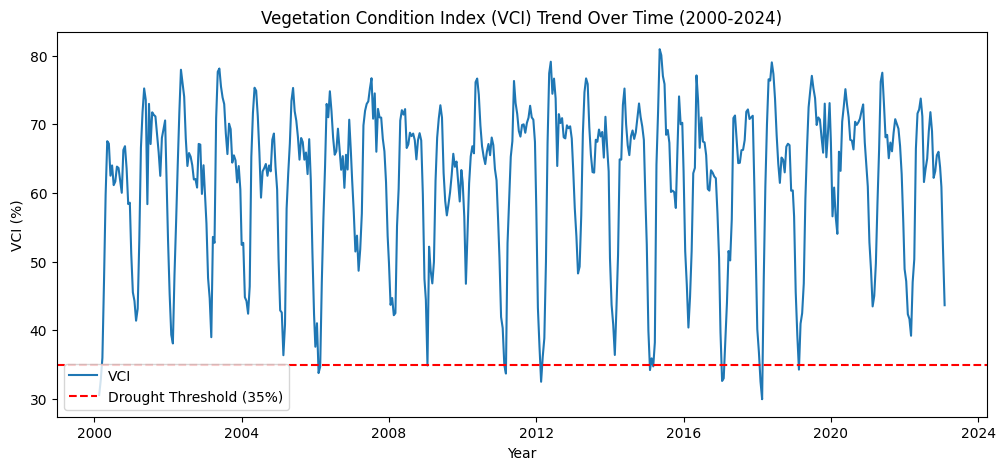

In [ ]:
import matplotlib.pyplot as plt

# Plot the VCI values over time
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['VCI'], label='VCI')
plt.axhline(y=35, color='r', linestyle='--', label="Drought Threshold (35%)")
plt.xlabel("Year")
plt.ylabel("VCI (%)")
plt.title("Vegetation Condition Index (VCI) Trend Over Time (2000-2024)")
plt.legend()
plt.show()


decomposing time series to see trends and plots

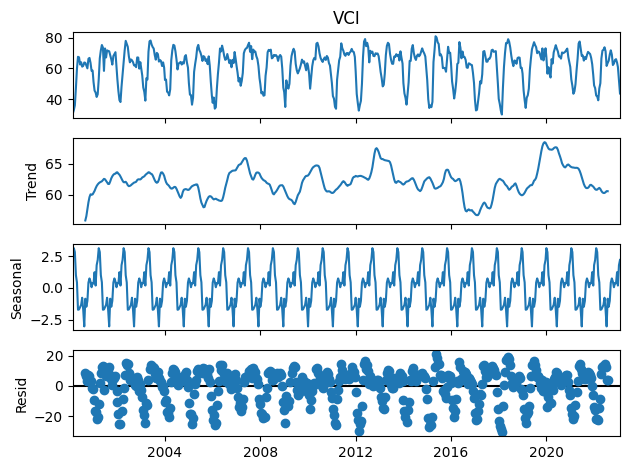

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose time series
decomposition = seasonal_decompose(df.set_index('Date')['VCI'], model='additive', period=24)
decomposition.plot()
plt.show()


for biweekly plots

<Figure size 1600x1200 with 0 Axes>

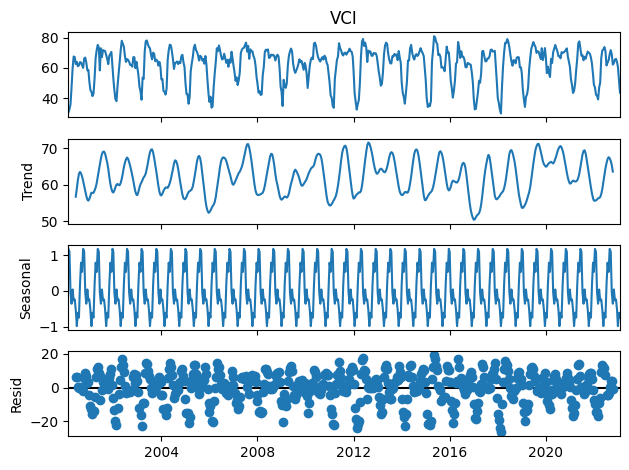

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming your data has daily frequency:
biweekly_period = 14  # 14 days in a bi-weekly period

# Decompose time series with biweekly period
decomposition = seasonal_decompose(df.set_index('Date')['VCI'], model='additive', period=biweekly_period)

# Create a larger figure
plt.figure(figsize=(16, 12))  # Adjust width and height as needed
decomposition.plot()
plt.show()

preparing data for lstm model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize VCI values (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
df['VCI_Scaled'] = scaler.fit_transform(df[['VCI']])

# Convert to supervised learning format (LSTM needs sequences)
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])  # Take `time_steps` previous values
        y.append(data[i+time_steps])  # Target is the next VCI value
    return np.array(X), np.array(y)

# Define time step (how many past observations to consider)
time_steps = 12  # 1 year worth of past data (24 images per year, adjust if needed)

# Create sequences
X, y = create_sequences(df['VCI_Scaled'].values, time_steps)

# Split into train (80%) and test (20%)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape X to 3D array (samples, timesteps, features) for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("LSTM Input Shape:", X_train.shape)


NameError: name 'df' is not defined

build and train LSTM model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.2616 - val_loss: 0.0579
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0790 - val_loss: 0.0442
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0565 - val_loss: 0.0399
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0606 - val_loss: 0.0373
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0486 - val_loss: 0.0303
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0413 - val_loss: 0.0337
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0422 - val_loss: 0.0291
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0356 - val_loss: 0.0336
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0369 - val_loss: 0.0251
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0361 - val_loss: 0.0269
Epoch 11/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0344 - val_loss: 0.0211
Epoch 12/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

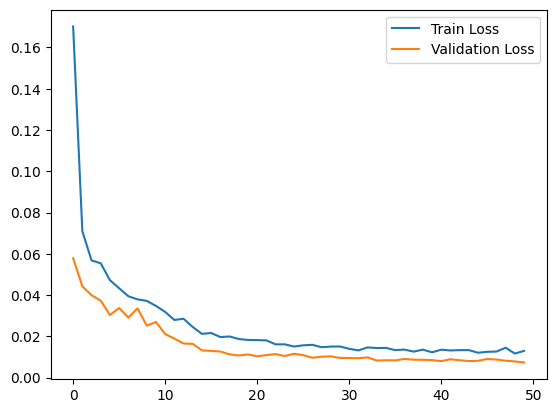

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model
model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer (1 VCI value)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

# Plot training loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


forecasting

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


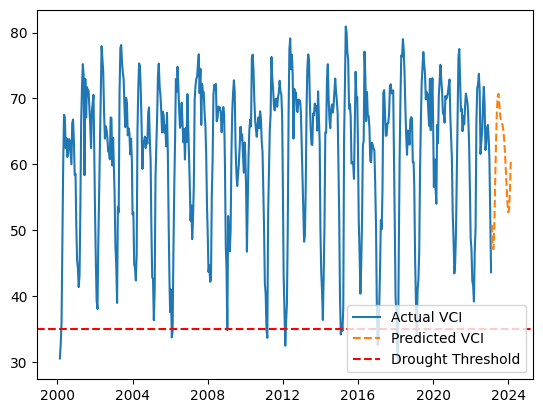

In [ ]:
future_steps = 24  # Predict for 1 year (24 MODIS time steps)
future_predictions = []

last_sequence = X_test[-1]  # Start with last known data

for _ in range(future_steps):
    pred = model.predict(last_sequence.reshape(1, time_steps, 1))[0][0]
    future_predictions.append(pred)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = pred

# Inverse transform to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create dates for predictions
future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_steps+1, freq='16D')[1:]

# Plot predictions
plt.plot(df['Date'], df['VCI'], label="Actual VCI")
plt.plot(future_dates, future_predictions, label="Predicted VCI", linestyle='dashed')
plt.axhline(y=35, color='r', linestyle='--', label="Drought Threshold")
plt.legend()
plt.show()


plot predicted vci data

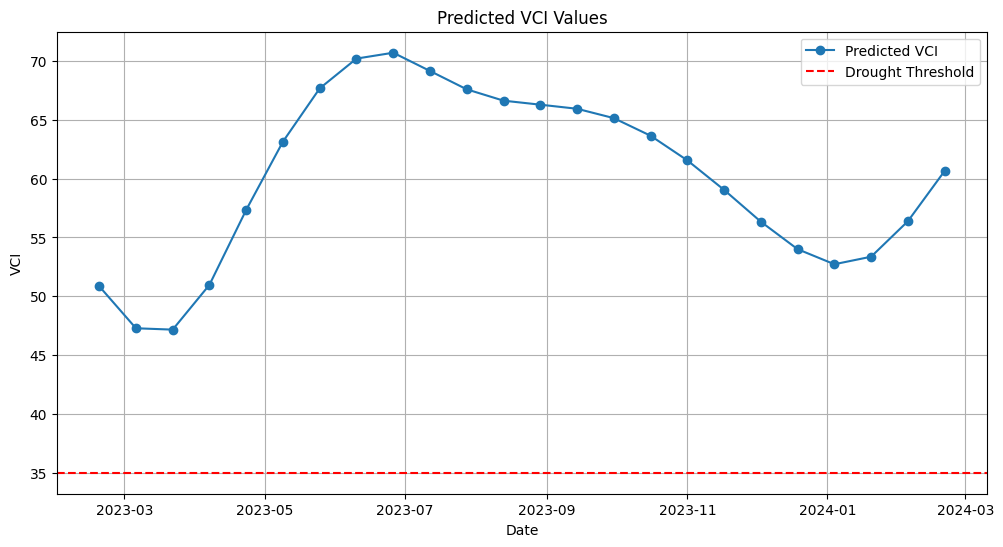

In [ ]:
# prompt: plot predict vci above

import matplotlib.pyplot as plt
# Assuming 'future_dates' and 'future_predictions' are already defined from the previous code.

plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, label='Predicted VCI', marker='o', linestyle='-')
plt.axhline(y=35, color='r', linestyle='--', label='Drought Threshold')
plt.xlabel('Date')
plt.ylabel('VCI')
plt.title('Predicted VCI Values')
plt.legend()
plt.grid(True)
plt.show()


visualize vci predicted maps

In [ ]:
# prompt: predicted vci conversion to  drought maps

# Assuming 'future_dates' and 'future_predictions' are already defined and contain the predicted VCI values and corresponding dates.
# Also, assuming you have a way to associate VCI values with geographic locations (e.g., latitude and longitude).

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Sample geographic data (replace with your actual data)
# Example coordinates (replace with your actual coordinates)
lats = [37.7749, 34.0522, 40.7128]  # Example latitudes
lons = [-122.4194, -118.2437, -74.0060]  # Example longitudes

# Create the figure and axes with cartopy projection
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())  # Choose a suitable projection

# Add coastlines and land features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle=':')


# Function to create a colormap for VCI (customize as needed)
def vci_colormap(value):
    if value < 15:
        return 'red'  # Extreme Drought
    elif value < 35:
        return 'orange'  # Severe Drought
    elif value < 50:
        return 'yellow'  # Moderate Drought
    else:
        return 'green'  # No Drought

# Plot the predicted VCI values on the map
# Assuming future_predictions aligns with the lats/lons
for i in range(len(future_predictions)):
  plt.scatter(lons, lats, color=vci_colormap(future_predictions[i]), transform=ccrs.PlateCarree(), label=f"Date: {future_dates[i].strftime('%Y-%m-%d')}", s=50, alpha=0.75)

# Add a colorbar (optional, but helpful)

# Add title and labels
plt.title('Predicted VCI on Map', fontsize=14)


# Add a legend to show the dates associated with each scatter plot point.
plt.legend(loc='lower left')


# Set map extent (optional, to focus on a specific region)
ax.set_extent([-125, -65, 25, 50], ccrs.PlateCarree()) # adjust as necessary


plt.show()


using geopandas to represent the predicted vci

Generating URL ...
Please wait ...
Data downloaded to /content/uganda.shp


/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.11/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
<ipython-input-21-00c0f6e56663>:61: UserWarning: Geometry is in a geographic CRS. Resul

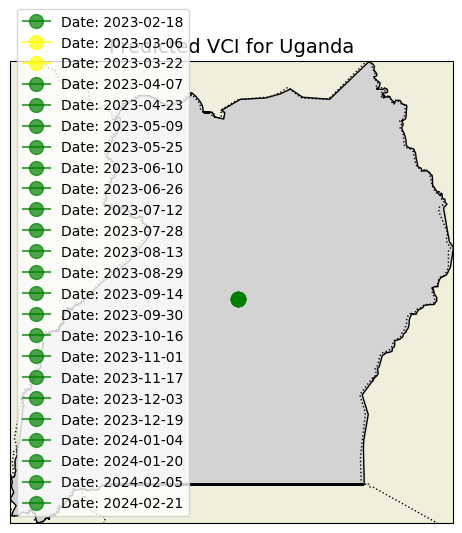

In [ ]:
# prompt: predicted vci conversion to drought maps using geopandas, downloading Uganda shapefile
!pip install geemap earthengine-api
import ee
import geemap
import matplotlib.pyplot as plt
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# **Authenticate and Initialize Earth Engine**
# You'll need to authenticate with your Google account and provide
# your Google Cloud Project ID if necessary.
# 1. Run `earthengine authenticate` in your terminal or use the following:
# ee.Authenticate()
# 2. Initialize with your project (if needed):
# ee.Initialize(project='your-google-cloud-project-id')
# **Replace 'your-google-cloud-project-id' with your actual project ID**
ee.Initialize(project='ee-muwanguzipaul980') # If ee.Authenticate() is successful the project initializes

# Get Uganda shapefile from FAO/GAUL/2015/level0
countries = ee.FeatureCollection("FAO/GAUL/2015/level0")
uganda = countries.filter(ee.Filter.eq('ADM0_NAME', 'Uganda'))

# Download the shapefile to a local file (e.g., 'uganda.shp')
# geemap.ee_export_vector(uganda, filename='uganda.shp', file_per_shape=False) # Removed the 'file_per_shape' argument
geemap.ee_export_vector(uganda, filename='uganda.shp')  # Use this instead

# Read the downloaded shapefile using geopandas
uganda = gpd.read_file('uganda.shp')

# Assuming 'future_dates' and 'future_predictions' are already defined
# Create the figure and axes with cartopy projection
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add coastlines and land features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Function to create a colormap for VCI (customize as needed)
def vci_colormap(value):
    if value < 15:
        return 'red'  # Extreme Drought
    elif value < 35:
        return 'orange'  # Severe Drought
    elif value < 50:
        return 'yellow'  # Moderate Drought
    else:
        return 'green'  # No Drought

# Plot Uganda shapefile
uganda.plot(ax=ax, color='lightgray', edgecolor='black')  # Base map of Uganda

# Assuming a single VCI prediction for the whole country
# You might need to adapt this part if you have regional VCI predictions
for i in range(len(future_predictions)):
    color = vci_colormap(future_predictions[i][0])  # Get color for VCI value
    # You can use a representative point for Uganda or plot a filled polygon
    plt.plot(uganda.geometry.centroid.x, uganda.geometry.centroid.y,
             marker='o', color=color, markersize=10,
             transform=ccrs.PlateCarree(), alpha=0.7,
             label=f"Date: {future_dates[i].strftime('%Y-%m-%d')}")

# Add title and legend
plt.title('Predicted VCI for Uganda', fontsize=14)
plt.legend(loc='lower left')

# Set map extent to focus on Uganda
ax.set_extent([uganda.total_bounds[0], uganda.total_bounds[2],
               uganda.total_bounds[1], uganda.total_bounds[3]],
              crs=ccrs.PlateCarree())

plt.show()

In [ ]:
!pip install cartopy
import cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 64.8 MB/s eta 0:00:00


VISUALS

In [ ]:
import pandas as pd
import glob
import os
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
import numpy as np

drive.mount('/content/drive')

folder_path = "/content/drive/My Drive/drought_prediction_project/vci"

all_files = glob.glob(folder_path + "/*.csv")
df_list = []

for file in all_files:
    if os.stat(file).st_size > 0:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file}")
    else:
        print(f"Skipping empty file: {file}")

# Combine all CSVs into one DataFrame
df = pd.concat(df_list, ignore_index=True)

# Convert date column to datetime format (modify if your column name is different)
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date (just in case)
df = df.sort_values(by='Date')

# Now you can use 'df'
# Normalize VCI values (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
df['VCI_Scaled'] = scaler.fit_transform(df[['VCI']])


Mounted at /content/drive


In [ ]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize VCI values (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
df['VCI_Scaled'] = scaler.fit_transform(df[['VCI']])

# Convert to supervised learning format (LSTM needs sequences)
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])  # Take `time_steps` previous values
        y.append(data[i+time_steps])  # Target is the next VCI value
    return np.array(X), np.array(y)

# Define time step (how many past observations to consider)
time_steps = 12  # 1 year worth of past data (24 images per year, adjust if needed)

# Create sequences
X, y = create_sequences(df['VCI_Scaled'].values, time_steps)

# Split into train (80%) and test (20%)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape X to 3D array (samples, timesteps, features) for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("LSTM Input Shape:", X_train.shape)


LSTM Input Shape: (836, 12, 1)


WHERE I first load the shapefile

In [ ]:
# Import the necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from folium import Choropleth
from google.colab import files  # Import files to upload
import tensorflow as tf # Import TensorFlow

# Upload the shapefile to the Colab environment
uploaded = files.upload()

# Read the uploaded shapefile
uganda = gpd.read_file("UG.shp")  # Assuming your shapefile name is 'UG.shp'

# Step 2: Prepare Future Predictions Data

# Define and compile the LSTM model (from previous code)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)  # Output layer (1 VCI value)
])

model.compile(optimizer='adam', loss='mse')

# Assuming you have X_train and y_train from previous code
# Train the model here if you haven't already
# history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

future_steps = 24  # Predict for 1 year (24 MODIS time steps)
future_predictions = []

last_sequence = X_test[-1]  # Start with last known data

for _ in range(future_steps):
    pred = model.predict(last_sequence.reshape(1, time_steps, 1))[0][0]
    future_predictions.append(pred)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = pred


# Inverse transform to original scale
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create dates for predictions
future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_steps+1, freq='16D')[1:]

# Step 3: Convert Predictions to GeoDataFrame
uganda['VCI'] = future_predictions[:len(uganda)]  # Assign VCI values to each region

# Step 4: Categorize Drought Severity
def classify_drought(vci):
    if vci < 35:
        return "Severe Drought"
    elif 35 <= vci < 50:
        return "Moderate Drought"
    else:
        return "No Drought"

uganda['Drought_Level'] = uganda['VCI'].apply(classify_drought)

# Step 5: Generate a Choropleth Map
m = folium.Map(location=[1.3733, 32.2903], zoom_start=6)  # Uganda center

# Add Drought Level Visualization
choropleth = Choropleth(
    geo_data=uganda,
    name="Drought Map",
    data=uganda,
    columns=["VCI", "Drought_Level"],
    key_on="feature.properties.VCI",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="VCI Drought Levels"
).add_to(m)

# Step 6: Save & Display Map
folium.LayerControl().add_to(m)
m.save("uganda_drought_map.html")
m

Saving UG.cpg to UG (2).cpg
Saving UG.dbf to UG (2).dbf
Saving UG.prj to UG (2).prj
Saving UG.qmd to UG (2).qmd
Saving UG.shp to UG (3).shp
Saving UG.shx to UG (2).shx


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
# Import the necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from folium import Choropleth
from google.colab import files  # Import files to upload
import tensorflow as tf  # Import TensorFlow
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# 1. Data Loading and Preprocessing
folder_path = "/content/drive/My Drive/drought_prediction_project/vci"
all_files = glob.glob(folder_path + "/*.csv")
df_list = []

for file in all_files:
    if os.stat(file).st_size > 0:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file}")
    else:
        print(f"Skipping empty file: {file}")

df = pd.concat(df_list, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Normalize VCI values (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
df['VCI_Scaled'] = scaler.fit_transform(df[['VCI']])

# Convert to supervised learning format
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(df['VCI_Scaled'].values, time_steps)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 2. LSTM Model Definition and Training
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model (if not already trained)
# history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


# 3. Future Predictions
future_steps = 24
future_predictions = []
last_sequence = X_test[-1]

for _ in range(future_steps):
    pred = model.predict(last_sequence.reshape(1, time_steps, 1))[0][0]
    future_predictions.append(pred)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = pred

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_steps + 1, freq='16D')[1:]


# 4. GeoDataFrame and Choropleth Map
# Upload the shapefile
uploaded = files.upload()
uganda = gpd.read_file("UG.shp")

# Assign VCI values and categorize drought severity
uganda['VCI'] = future_predictions[:len(uganda)].astype(float)  # Convert to float

def classify_drought(vci):
    if vci < 35:
        return "Severe Drought"
    elif 35 <= vci < 50:
        return "Moderate Drought"
    else:
        return "No Drought"

uganda['Drought_Level'] = uganda['VCI'].apply(classify_drought)

# Create the Choropleth map
m = folium.Map(location=[1.3733, 32.2903], zoom_start=6)

choropleth = Choropleth(
    geo_data=uganda,
    name="Drought Map",
    data=uganda,
    columns=["Drought_Level", "VCI"],  # Use Drought_Level as key
    key_on="feature.properties.Drought_Level",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="VCI Drought Levels"
).add_to(m)

folium.LayerControl().add_to(m)
m.save("uganda_drought_map.html")
m

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


Saving UG.cpg to UG (3).cpg
Saving UG.dbf to UG (3).dbf
Saving UG.prj to UG (3).prj
Saving UG.qmd to UG (3).qmd
Saving UG.shp to UG (4).shp
Saving UG.shx to UG (3).shx


for biweekly maps

In [ ]:
# Import the necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from folium import Choropleth
from google.colab import files  # Import files to upload
import tensorflow as tf  # Import TensorFlow
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from IPython.display import display

# Mount Google Drive
drive.mount('/content/drive')

# 1. Data Loading and Preprocessing
folder_path = "/content/drive/My Drive/drought_prediction_project/vci"
all_files = glob.glob(folder_path + "/*.csv")
df_list = []

for file in all_files:
    if os.stat(file).st_size > 0:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file}")
    else:
        print(f"Skipping empty file: {file}")

df = pd.concat(df_list, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Normalize VCI values (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
df['VCI_Scaled'] = scaler.fit_transform(df[['VCI']])

# Convert to supervised learning format
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(df['VCI_Scaled'].values, time_steps)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 2. LSTM Model Definition and Training
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model (if not already trained)
# history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


# 3. Future Predictions
future_steps = 24
future_predictions = []
last_sequence = X_test[-1]

for _ in range(future_steps):
    pred = model.predict(last_sequence.reshape(1, time_steps, 1))[0][0]
    future_predictions.append(pred)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = pred

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_steps + 1, freq='16D')[1:]


# 4. GeoDataFrame and Choropleth Maps (Biweekly)
# Upload the shapefile
uploaded = files.upload()
uganda = gpd.read_file("UG.shp")

# Biweekly interval (14 days)
biweekly_interval = 14

# Create a list to store the generated maps
maps = []

# Function to classify drought severity
def classify_drought(vci):
    if vci < 35:
        return "Severe Drought"
    elif 35 <= vci < 50:
        return "Moderate Drought"
    else:
        return "No Drought"


# Iterate through the predictions in biweekly intervals
for i in range(0, len(future_predictions), biweekly_interval):
    # Get the VCI predictions for the current biweekly interval
    current_vci = future_predictions[i : i + biweekly_interval]

    # Assign VCI values to the GeoDataFrame for the current interval
    uganda['VCI'] = current_vci[:len(uganda)].astype(float)

    # Categorize drought severity for the current interval
    uganda['Drought_Level'] = uganda['VCI'].apply(classify_drought)

    # Create the Choropleth map for the current interval
    m = folium.Map(location=[1.3733, 32.2903], zoom_start=6)

    choropleth = Choropleth(
        geo_data=uganda,
        name="Drought Map",
        data=uganda,
        columns=["Drought_Level", "VCI"],
        key_on="feature.properties.Drought_Level",
        fill_color="YlOrRd",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name="VCI Drought Levels"
    ).add_to(m)

    # Add the date of the biweekly interval to the map title
    date_range = (
        future_dates[i].strftime('%Y-%m-%d')
        + " to "
        + future_dates[min(i + biweekly_interval - 1, len(future_dates) - 1)].strftime('%Y-%m-%d')
    )
    choropleth.geojson.add_child(folium.Popup(date_range))
    m.add_child(folium.LatLngPopup())

    # Append the map to the list of maps
    maps.append(m)

# Save all maps as HTML files (optional)
for i, map_obj in enumerate(maps):
    map_obj.save(f"uganda_drought_map_{i}.html")

# Display all the maps (in Colab, they'll be shown one after another)
for map_obj in maps:
    display(map_obj)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Saving UG.cpg to UG (4).cpg
Saving UG.dbf to UG (4).dbf
Saving UG.prj to UG (4).prj
Saving UG.qmd to UG (4).qmd
Saving UG.shp to UG (5).shp
Saving UG.shx to UG (4).shx


adding plots and other necesarry things

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 886ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


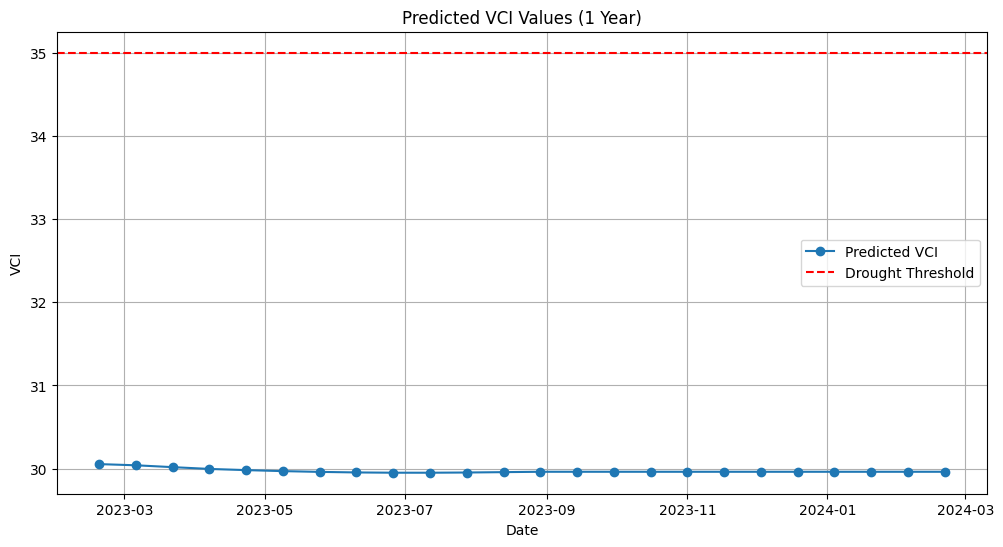

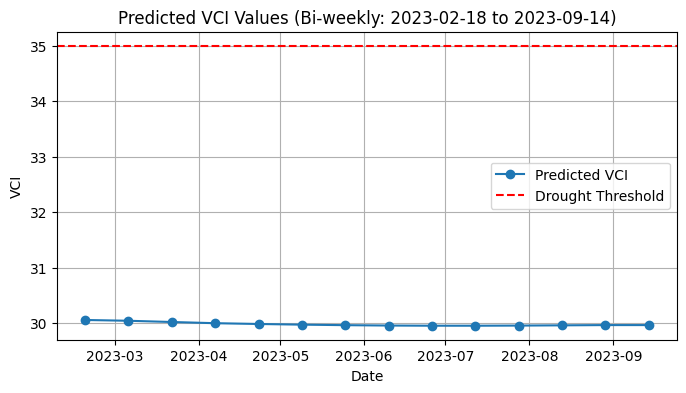

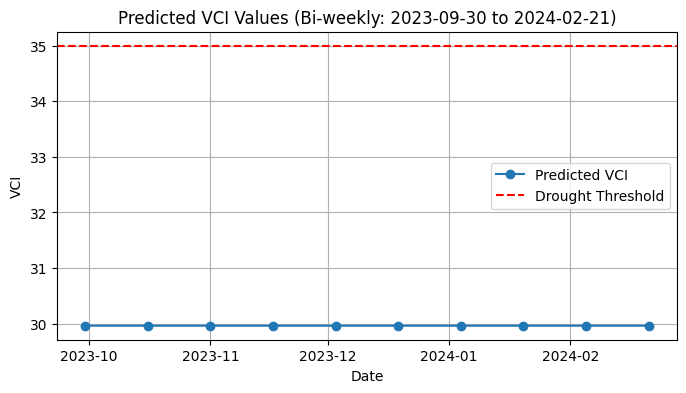

Saving UG.cpg to UG (5).cpg
Saving UG.dbf to UG (5).dbf
Saving UG.prj to UG (5).prj
Saving UG.qmd to UG (5).qmd
Saving UG.shp to UG (6).shp
Saving UG.shx to UG (5).shx


In [ ]:
# Import the necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from folium import Choropleth
from google.colab import files  # Import files to upload
import tensorflow as tf  # Import TensorFlow
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from IPython.display import display
import matplotlib.pyplot as plt # Import for plotting

# Mount Google Drive
drive.mount('/content/drive')

# 1. Data Loading and Preprocessing
folder_path = "/content/drive/My Drive/drought_prediction_project/vci"
all_files = glob.glob(folder_path + "/*.csv")
df_list = []

for file in all_files:
    if os.stat(file).st_size > 0:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file}")
    else:
        print(f"Skipping empty file: {file}")

df = pd.concat(df_list, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Normalize VCI values (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
df['VCI_Scaled'] = scaler.fit_transform(df[['VCI']])

# Convert to supervised learning format
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(df['VCI_Scaled'].values, time_steps)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 2. LSTM Model Definition and Training
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model (if not already trained)
# history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


# 3. Future Predictions
future_steps = 24
future_predictions = []
last_sequence = X_test[-1]

for _ in range(future_steps):
    pred = model.predict(last_sequence.reshape(1, time_steps, 1))[0][0]
    future_predictions.append(pred)
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = pred

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_steps + 1, freq='16D')[1:]


# --- Plotting Predictions ---

# 1. Plot for all predictions (1 year)
plt.figure(figsize=(12, 6))
plt.plot(future_dates, future_predictions, label='Predicted VCI', marker='o', linestyle='-')
plt.axhline(y=35, color='r', linestyle='--', label='Drought Threshold')
plt.xlabel('Date')
plt.ylabel('VCI')
plt.title('Predicted VCI Values (1 Year)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Bi-weekly plots within the 1-year prediction
biweekly_interval = 14  # 14 days for bi-weekly plots

for i in range(0, len(future_predictions), biweekly_interval):
    # Get data for the current bi-weekly period
    start_index = i
    end_index = min(i + biweekly_interval, len(future_predictions))
    current_dates = future_dates[start_index:end_index]
    current_vci = future_predictions[start_index:end_index]

    # Create bi-weekly plot
    plt.figure(figsize=(8, 4))  # Adjust figure size as needed
    plt.plot(current_dates, current_vci, label='Predicted VCI', marker='o', linestyle='-')
    plt.axhline(y=35, color='r', linestyle='--', label='Drought Threshold')
    plt.xlabel('Date')
    plt.ylabel('VCI')
    plt.title(f'Predicted VCI Values (Bi-weekly: {current_dates[0].strftime("%Y-%m-%d")} to {current_dates[-1].strftime("%Y-%m-%d")})')
    plt.legend()
    plt.grid(True)
    plt.show()



# 4. GeoDataFrame and Choropleth Maps (Biweekly)
# Upload the shapefile
uploaded = files.upload()
uganda = gpd.read_file("UG.shp")

# Biweekly interval (14 days)
biweekly_interval = 14

# Create a list to store the generated maps
maps = []

# Function to classify drought severity
def classify_drought(vci):
    if vci < 35:
        return "Severe Drought"
    elif 35 <= vci < 50:
        return "Moderate Drought"
    else:
        return "No Drought"


# Iterate through the predictions in biweekly intervals
for i in range(0, len(future_predictions), biweekly_interval):
    # Get the VCI predictions for the current biweekly interval
    current_vci = future_predictions[i : i + biweekly_interval]

    # Assign VCI values to the GeoDataFrame for the current interval
    uganda['VCI'] = current_vci[:len(uganda)].astype(float)

    # Categorize drought severity for the current interval
    uganda['Drought_Level'] = uganda['VCI'].apply(classify_drought)

    # Create the Choropleth map for the current interval
    m = folium.Map(location=[1.3733, 32.2903], zoom_start=6)

    choropleth = Choropleth(
        geo_data=uganda,
        name="Drought Map",
        data=uganda,
        columns=["Drought_Level", "VCI"],
        key_on="feature.properties.Drought_Level",
        fill_color="YlOrRd",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name="VCI Drought Levels"
    ).add_to(m)

    # Add the date of the biweekly interval to the map title
    date_range = (
        future_dates[i].strftime('%Y-%m-%d')
        + " to "
        + future_dates[min(i + biweekly_interval - 1, len(future_dates) - 1)].strftime('%Y-%m-%d')
    )
    choropleth.geojson.add_child(folium.Popup(date_range))
    m.add_child(folium.LatLngPopup())

    # Append the map to the list of maps
    maps.append(m)

# Save all maps as HTML files (optional)
for i, map_obj in enumerate(maps):
    map_obj.save(f"uganda_drought_map_{i}.html")

# Display all the maps (in Colab, they'll be shown one after another)
for map_obj in maps:
    display(map_obj)

up werent real biweekly data now another trial

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━

ValueError: x and y must have same first dimension, but have shapes (24,) and (28, 1)

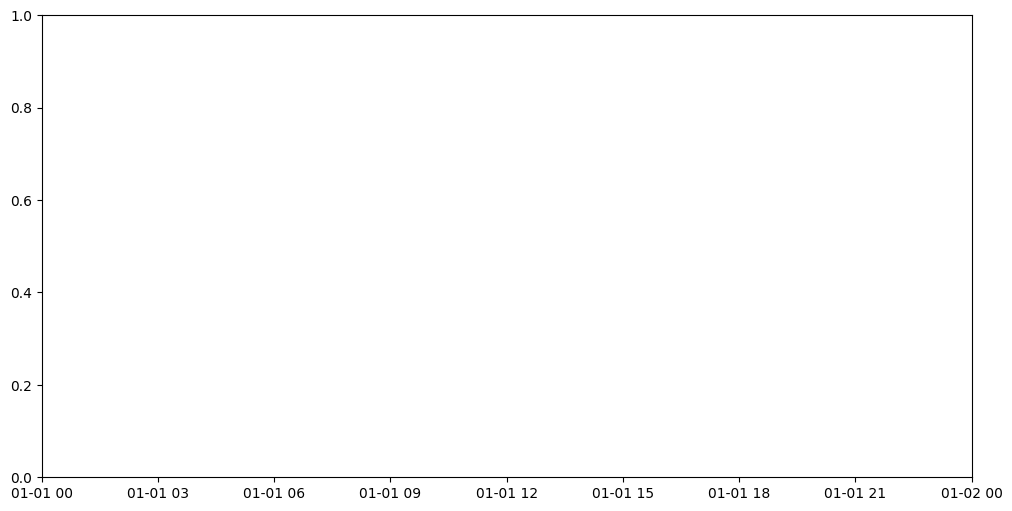

In [ ]:
# Import the necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from folium import Choropleth
from google.colab import files  # Import files to upload
import tensorflow as tf  # Import TensorFlow
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from IPython.display import display
import matplotlib.pyplot as plt # Import for plotting
import os # Required for os.stat
import glob # Import the glob module

# Mount Google Drive
drive.mount('/content/drive')

# 1. Data Loading and Preprocessing
folder_path = "/content/drive/My Drive/drought_prediction_project/vci"
all_files = glob.glob(folder_path + "/*.csv")
df_list = []

for file in all_files:
    if os.stat(file).st_size > 0:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file}")
    else:
        print(f"Skipping empty file: {file}")

df = pd.concat(df_list, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Normalize VCI values (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
df['VCI_Scaled'] = scaler.fit_transform(df[['VCI']])

# Convert to supervised learning format
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(df['VCI_Scaled'].values, time_steps)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 2. LSTM Model Definition and Training
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model (if not already trained)
# history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


# 3. Future Predictions (Rolling Bi-weekly)
future_steps = 24  # Total prediction period (1 year)
biweekly_interval = 14  # 14 days for bi-weekly prediction

# Initialize an empty list to store all predictions
all_predictions = []

# Initial input sequence for prediction (last sequence from training data)
current_sequence = X_test[-1]

# Generate predictions for the entire prediction period
for i in range(0, future_steps, biweekly_interval):
    # Predict for the next biweekly_interval (2 weeks)
    biweekly_predictions = []
    for _ in range(biweekly_interval):
        pred = model.predict(current_sequence.reshape(1, time_steps, 1))[0][0]
        biweekly_predictions.append(pred)

        # Update the current sequence for the next prediction
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = pred

    # Append the biweekly predictions to the overall predictions list
    all_predictions.extend(biweekly_predictions)

# Inverse transform all predictions back to original scale
all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))

# Create future dates for the entire prediction period
future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=future_steps + 1, freq='16D')[1:]


# --- Plotting Predictions ---

# 1. Plot for all predictions (1 year)
plt.figure(figsize=(12, 6))
plt.plot(future_dates, all_predictions, label='Predicted VCI', marker='o', linestyle='-')
plt.axhline(y=35, color='r', linestyle='--', label='Drought Threshold')
plt.xlabel('Date')
plt.ylabel('VCI')
plt.title('Predicted VCI Values (1 Year)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Bi-weekly plots within the 1-year prediction
biweekly_interval = 14  # 14 days for bi-weekly plots

for i in range(0, len(all_predictions), biweekly_interval):
    # Get data for the current bi-weekly period
    start_index = i
    end_index = min(i + biweekly_interval, len(all_predictions))
    current_dates = future_dates[start_index:end_index]
    current_vci = all_predictions[start_index:end_index]

    # Create bi-weekly plot
    plt.figure(figsize=(8, 4))  # Adjust figure size as needed
    plt.plot(current_dates, current_vci, label='Predicted VCI', marker='o', linestyle='-')
    plt.axhline(y=35, color='r', linestyle='--', label='Drought Threshold')
    plt.xlabel('Date')
    plt.ylabel('VCI')
    plt.title(f'Predicted VCI Values (Bi-weekly: {current_dates[0].strftime("%Y-%m-%d")} to {current_dates[-1].strftime("%Y-%m-%d")})')
    plt.legend()
    plt.grid(True)
    plt.show()


# ... (Your existing code) ...

# 3. Future Predictions (Rolling Bi-weekly)
future_steps = 24  # Total prediction period (1 year)
biweekly_interval = 14  # 14 days for bi-weekly prediction

# Initialize an empty list to store all predictions
all_predictions = []

# Initial input sequence for prediction (last sequence from training data)
current_sequence = X_test[-1]

# Generate predictions for the entire prediction period
# Calculate the correct number of bi-weekly predictions
num_biweekly_steps = future_steps // biweekly_interval

# Adjust the loop to match the total steps
total_steps = num_biweekly_steps * biweekly_interval
for i in range(total_steps):
    pred = model.predict(current_sequence.reshape(1, time_steps, 1))[0][0]
    all_predictions.append(pred)
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[-1] = pred

# Inverse transform all predictions back to original scale
all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))

# Create future dates for the entire prediction period
future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=total_steps + 1, freq='16D')[1:]

# ... (The rest of your code) ...


# 4. GeoDataFrame and Choropleth Maps (Biweekly)
# Upload the shapefile
uploaded = files.upload()
uganda = gpd.read_file("UG.shp")

# Biweekly interval (14 days)
biweekly_interval = 14

# Create a list to store the generated maps
maps = []

# Function to classify drought severity
def classify_drought(vci):
    if vci < 35:
        return "Severe Drought"
    elif 35 <= vci < 50:
        return "Moderate Drought"
    else:
        return "No Drought"


# Iterate through the predictions in biweekly intervals
for i in range(0, len(all_predictions), biweekly_interval):
    # Get the VCI predictions for the current biweekly interval
    current_vci = all_predictions[i : i + biweekly_interval]

    # Assign VCI values to the GeoDataFrame for the current interval
    uganda['VCI'] = current_vci[:len(uganda)].astype(float)

    # Categorize drought severity for the current interval
    uganda['Drought_Level'] = uganda['VCI'].apply(classify_drought)

    # Create the Choropleth map for the current interval
    m = folium.Map(location=[1.3733, 32.2903], zoom_start=6)

    choropleth = Choropleth(
        geo_data=uganda,
        name="Drought Map",
        data=uganda,
        columns=["Drought_Level", "VCI"],
        key_on="feature.properties.Drought_Level",
        fill_color="YlOrRd",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name="VCI Drought Levels"
    ).add_to(m)

    # Add the date of the biweekly interval to the map title
    date_range = (
        future_dates[i].strftime('%Y-%m-%d')
        + " to "
        + future_dates[min(i + biweekly_interval - 1, len(future_dates) - 1)].strftime('%Y-%m-%d')
    )
    choropleth.geojson.add_child(folium.Popup(date_range))
    m.add_child(folium.LatLngPopup())

    # Append the map to the list of maps
    maps.append(m)

# Save all maps as HTML files (optional)
for i, map_obj in enumerate(maps):
    map_obj.save(f"uganda_drought_map_{i}.html")

# Display all the maps (in Colab, they'll be shown one after another)
for map_obj in maps:
    display(map_obj)

new debugged code for bi-weekly

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


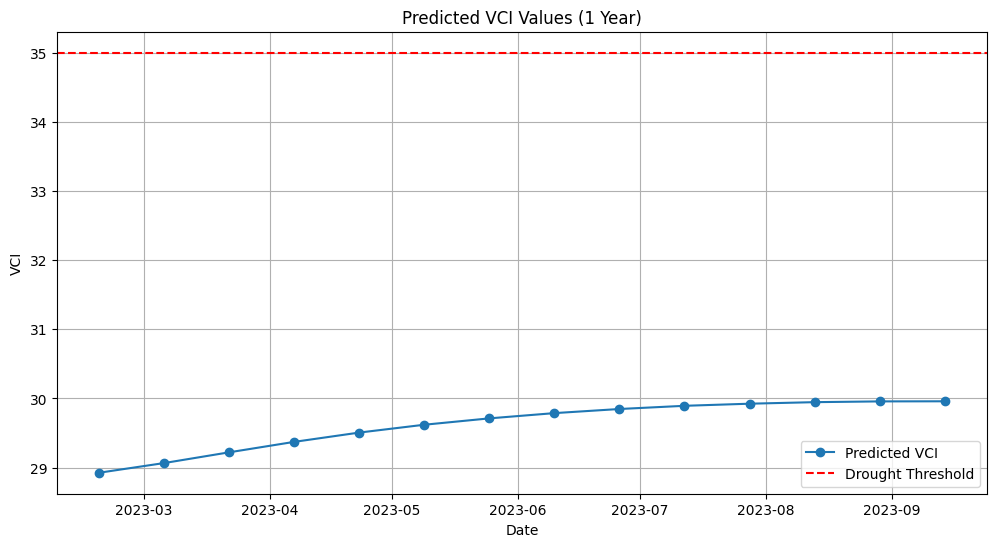

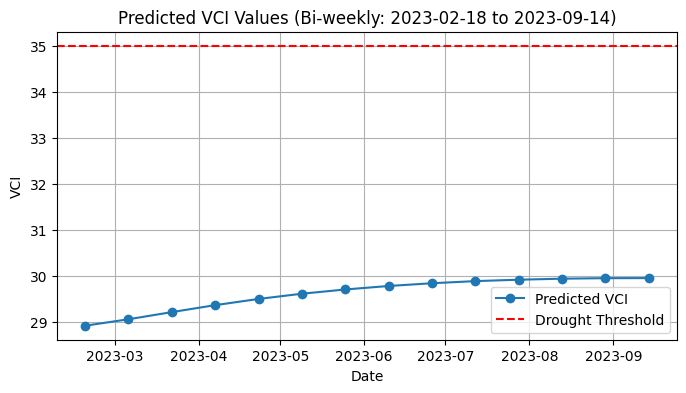

Saving UG.cpg to UG.cpg
Saving UG.dbf to UG.dbf
Saving UG.prj to UG.prj
Saving UG.qmd to UG.qmd
Saving UG.shp to UG.shp
Saving UG.shx to UG.shx


In [ ]:
# Import the necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from folium import Choropleth
from google.colab import files  # Import files to upload
import tensorflow as tf  # Import TensorFlow
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from IPython.display import display
import matplotlib.pyplot as plt # Import for plotting
import os # Required for os.stat
import glob # Import the glob module

# Mount Google Drive
drive.mount('/content/drive')

# 1. Data Loading and Preprocessing
folder_path = "/content/drive/My Drive/drought_prediction_project/vci"
all_files = glob.glob(folder_path + "/*.csv")
df_list = []

for file in all_files:
    if os.stat(file).st_size > 0:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file}")
    else:
        print(f"Skipping empty file: {file}")

df = pd.concat(df_list, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Normalize VCI values (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
df['VCI_Scaled'] = scaler.fit_transform(df[['VCI']])

# Convert to supervised learning format
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(df['VCI_Scaled'].values, time_steps)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 2. LSTM Model Definition and Training
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model (if not already trained)
# history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


# 3. Future Predictions (Rolling Bi-weekly)
future_steps = 24  # Total prediction period (1 year)
biweekly_interval = 14  # 14 days for bi-weekly prediction

# Initialize an empty list to store all predictions
all_predictions = []

# Initial input sequence for prediction (last sequence from training data)
current_sequence = X_test[-1]

# Generate predictions for the entire prediction period
# Calculate the correct number of bi-weekly predictions
num_biweekly_steps = future_steps // biweekly_interval

# Adjust the loop to match the total steps
total_steps = num_biweekly_steps * biweekly_interval

for _ in range(total_steps):  # Changed loop to iterate over all steps, not bi-weekly intervals
    pred = model.predict(current_sequence.reshape(1, time_steps, 1))[0][0]
    all_predictions.append(pred)
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[-1] = pred

# Inverse transform all predictions back to original scale
all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))

# Create future dates for the entire prediction period
# Fixed to use len(all_predictions) instead of future_steps
future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=len(all_predictions) + 1, freq='16D')[1:]


# --- Plotting Predictions ---

# 1. Plot for all predictions (1 year)
plt.figure(figsize=(12, 6))
plt.plot(future_dates, all_predictions, label='Predicted VCI', marker='o', linestyle='-')
plt.axhline(y=35, color='r', linestyle='--', label='Drought Threshold')
plt.xlabel('Date')
plt.ylabel('VCI')
plt.title('Predicted VCI Values (1 Year)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Bi-weekly plots within the 1-year prediction
biweekly_interval = 14  # 14 days for bi-weekly plots

for i in range(0, len(all_predictions), biweekly_interval):
    # Get data for the current bi-weekly period
    start_index = i
    end_index = min(i + biweekly_interval, len(all_predictions))
    current_dates = future_dates[start_index:end_index]
    current_vci = all_predictions[start_index:end_index]

    # Create bi-weekly plot
    plt.figure(figsize=(8, 4))  # Adjust figure size as needed
    plt.plot(current_dates, current_vci, label='Predicted VCI', marker='o', linestyle='-')
    plt.axhline(y=35, color='r', linestyle='--', label='Drought Threshold')
    plt.xlabel('Date')
    plt.ylabel('VCI')
    plt.title(f'Predicted VCI Values (Bi-weekly: {current_dates[0].strftime("%Y-%m-%d")} to {current_dates[-1].strftime("%Y-%m-%d")})')
    plt.legend()
    plt.grid(True)
    plt.show()



# 4. GeoDataFrame and Choropleth Maps (Biweekly)
# Upload the shapefile
uploaded = files.upload()
uganda = gpd.read_file("UG.shp")

# Biweekly interval (14 days)
biweekly_interval = 14

# Create a list to store the generated maps
maps = []

# Function to classify drought severity
def classify_drought(vci):
    if vci < 35:
        return "Severe Drought"
    elif 35 <= vci < 50:
        return "Moderate Drought"
    else:
        return "No Drought"


# Iterate through the predictions in biweekly intervals
for i in range(0, len(all_predictions), biweekly_interval):
    # Get the VCI predictions for the current biweekly interval
    current_vci = all_predictions[i : i + biweekly_interval]

    # Assign VCI values to the GeoDataFrame for the current interval
    uganda['VCI'] = current_vci[:len(uganda)].astype(float)

    # Categorize drought severity for the current interval
    uganda['Drought_Level'] = uganda['VCI'].apply(classify_drought)

    # Create the Choropleth map for the current interval
    m = folium.Map(location=[1.3733, 32.2903], zoom_start=6)

    choropleth = Choropleth(
        geo_data=uganda,
        name="Drought Map",
        data=uganda,
        columns=["Drought_Level", "VCI"],
        key_on="feature.properties.Drought_Level",
        fill_color="YlOrRd",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name="VCI Drought Levels"
    ).add_to(m)

    # Add the date of the biweekly interval to the map title
    date_range = (
        future_dates[i].strftime('%Y-%m-%d')
        + " to "
        + future_dates[min(i + biweekly_interval - 1, len(future_dates) - 1)].strftime('%Y-%m-%d')
    )
    choropleth.geojson.add_child(folium.Popup(date_range))
    m.add_child(folium.LatLngPopup())

    # Append the map to the list of maps
    maps.append(m)

# Save all maps as HTML files (optional)
for i, map_obj in enumerate(maps):
    map_obj.save(f"uganda_drought_map_{i}.html")

# Display all the maps (in Colab, they'll be shown one after another)
for map_obj in maps:
    display(map_obj)

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━

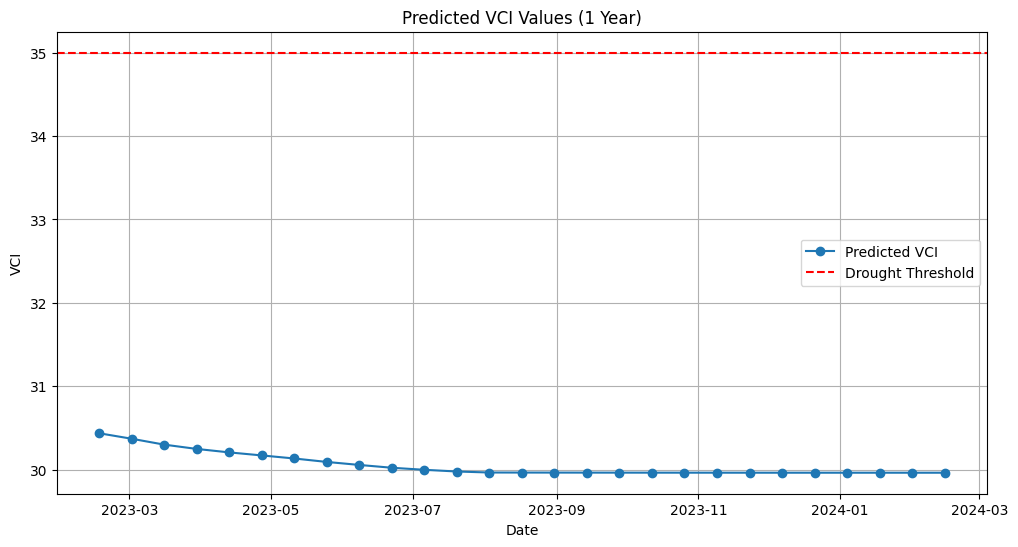

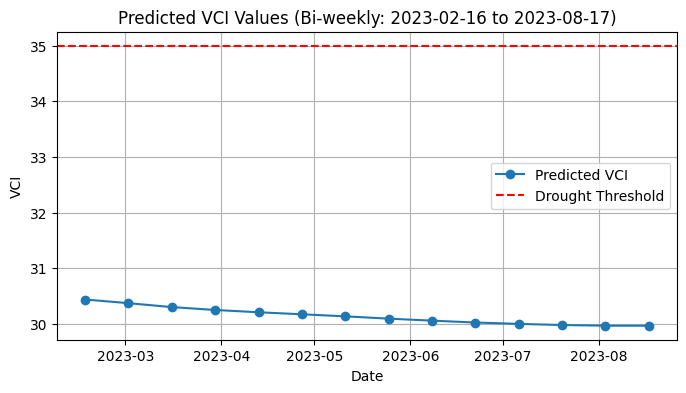

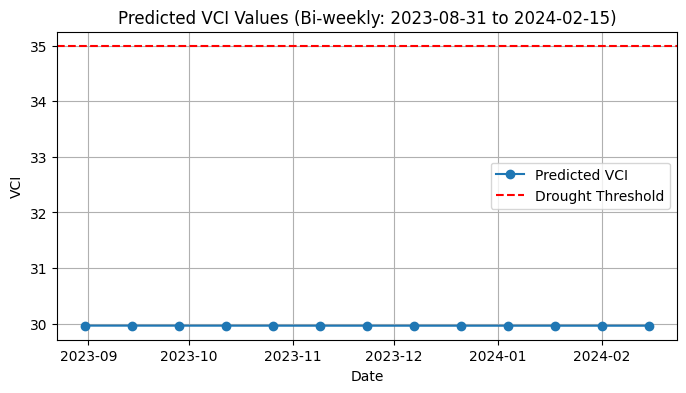

Saving UG.cpg to UG.cpg
Saving UG.dbf to UG.dbf
Saving UG.prj to UG.prj
Saving UG.qmd to UG.qmd
Saving UG.shp to UG.shp
Saving UG.shx to UG.shx


In [ ]:
# Import the necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from folium import Choropleth
from google.colab import files  # Import files to upload
import tensorflow as tf  # Import TensorFlow
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from IPython.display import display
import matplotlib.pyplot as plt  # Import for plotting
import os  # Required for os.stat
import glob  # Import the glob module

# Mount Google Drive
drive.mount('/content/drive')

# 1. Data Loading and Preprocessing
folder_path = "/content/drive/My Drive/drought_prediction_project/vci"
all_files = glob.glob(folder_path + "/*.csv")
df_list = []

for file in all_files:
    if os.stat(file).st_size > 0:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file}")
    else:
        print(f"Skipping empty file: {file}")

df = pd.concat(df_list, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Normalize VCI values (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
df['VCI_Scaled'] = scaler.fit_transform(df[['VCI']])

# Convert to supervised learning format
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(df['VCI_Scaled'].values, time_steps)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 2. LSTM Model Definition and Training
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model (if not already trained)
# history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


# 3. Future Predictions (Bi-weekly - 14 days)
future_steps = 24  # Total prediction period (1 year) - can adjust as needed
biweekly_interval = 14  # 14 days for bi-weekly prediction

# Assuming your data is at a 16-day frequency, adjust num_predictions:
num_predictions = future_steps * (16 / biweekly_interval)
num_predictions = int(num_predictions)  # Ensure it's an integer

all_predictions = []
current_sequence = X_test[-1]

for _ in range(num_predictions):
    pred = model.predict(current_sequence.reshape(1, time_steps, 1))[0][0]
    all_predictions.append(pred)
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[-1] = pred

all_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))

# Create future dates, accounting for the bi-weekly interval:
future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=num_predictions + 1, freq=f'{biweekly_interval}D')[1:]

# ... (rest of the code for plotting and creating maps) ...
# --- Plotting Predictions ---

# 1. Plot for all predictions (1 year)
plt.figure(figsize=(12, 6))
plt.plot(future_dates, all_predictions, label='Predicted VCI', marker='o', linestyle='-')
plt.axhline(y=35, color='r', linestyle='--', label='Drought Threshold')
plt.xlabel('Date')
plt.ylabel('VCI')
plt.title('Predicted VCI Values (1 Year)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Bi-weekly plots within the 1-year prediction
biweekly_interval = 14  # 14 days for bi-weekly plots

for i in range(0, len(all_predictions), biweekly_interval):
    # Get data for the current bi-weekly period
    start_index = i
    end_index = min(i + biweekly_interval, len(all_predictions))
    current_dates = future_dates[start_index:end_index]
    current_vci = all_predictions[start_index:end_index]

    # Create bi-weekly plot
    plt.figure(figsize=(8, 4))  # Adjust figure size as needed
    plt.plot(current_dates, current_vci, label='Predicted VCI', marker='o', linestyle='-')
    plt.axhline(y=35, color='r', linestyle='--', label='Drought Threshold')
    plt.xlabel('Date')
    plt.ylabel('VCI')
    plt.title(f'Predicted VCI Values (Bi-weekly: {current_dates[0].strftime("%Y-%m-%d")} to {current_dates[-1].strftime("%Y-%m-%d")})')
    plt.legend()
    plt.grid(True)
    plt.show()



# 4. GeoDataFrame and Choropleth Maps (Biweekly)
# Upload the shapefile
uploaded = files.upload()
uganda = gpd.read_file("UG.shp")

# Biweekly interval (14 days)
biweekly_interval = 14

# Create a list to store the generated maps
maps = []

# Function to classify drought severity
def classify_drought(vci):
    if vci < 35:
        return "Severe Drought"
    elif 35 <= vci < 50:
        return "Moderate Drought"
    else:
        return "No Drought"


# Iterate through the predictions in biweekly intervals
for i in range(0, len(all_predictions), biweekly_interval):
    # Get the VCI predictions for the current biweekly interval
    current_vci = all_predictions[i : i + biweekly_interval]

    # Assign VCI values to the GeoDataFrame for the current interval
    uganda['VCI'] = current_vci[:len(uganda)].astype(float)

    # Categorize drought severity for the current interval
    uganda['Drought_Level'] = uganda['VCI'].apply(classify_drought)

    # Create the Choropleth map for the current interval
    m = folium.Map(location=[1.3733, 32.2903], zoom_start=6)

    choropleth = Choropleth(
        geo_data=uganda,
        name="Drought Map",
        data=uganda,
        columns=["Drought_Level", "VCI"],
        key_on="feature.properties.Drought_Level",
        fill_color="YlOrRd",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name="VCI Drought Levels"
    ).add_to(m)

    # Add the date of the biweekly interval to the map title
    date_range = (
        future_dates[i].strftime('%Y-%m-%d')
        + " to "
        + future_dates[min(i + biweekly_interval - 1, len(future_dates) - 1)].strftime('%Y-%m-%d')
    )
    choropleth.geojson.add_child(folium.Popup(date_range))
    m.add_child(folium.LatLngPopup())

    # Append the map to the list of maps
    maps.append(m)

# Save all maps as HTML files (optional)
for i, map_obj in enumerate(maps):
    map_obj.save(f"uganda_drought_map_{i}.html")

# Display all the maps (in Colab, they'll be shown one after another)
for map_obj in maps:
    display(map_obj)

time step for bi-weekly interval set to 0.875 which translates to data every 14 days thus true biweekly

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━

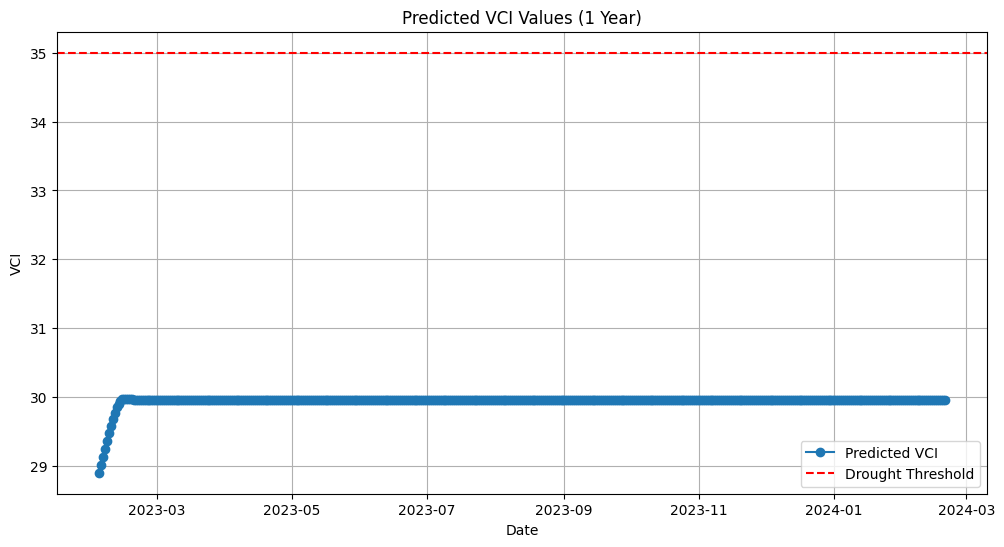

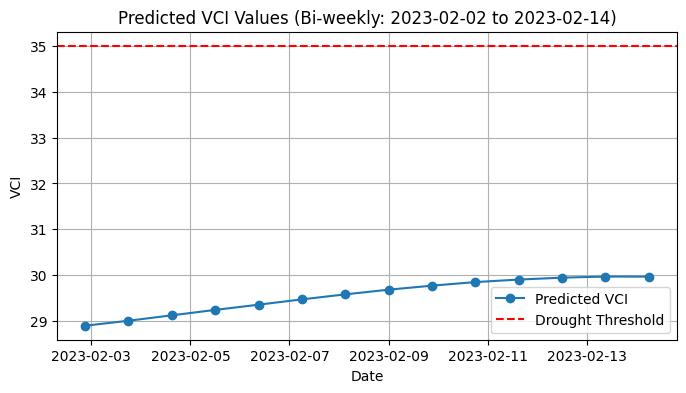

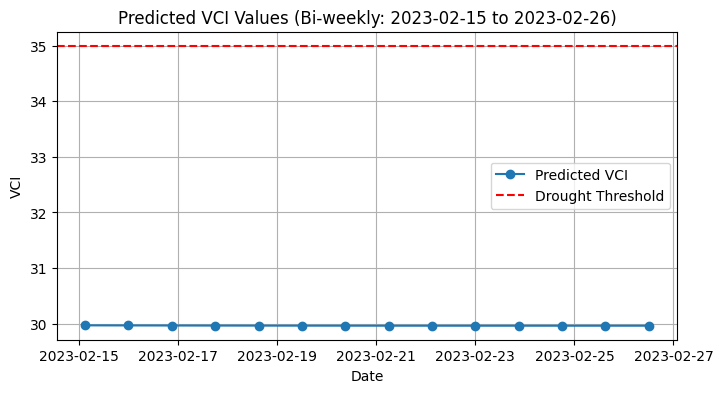

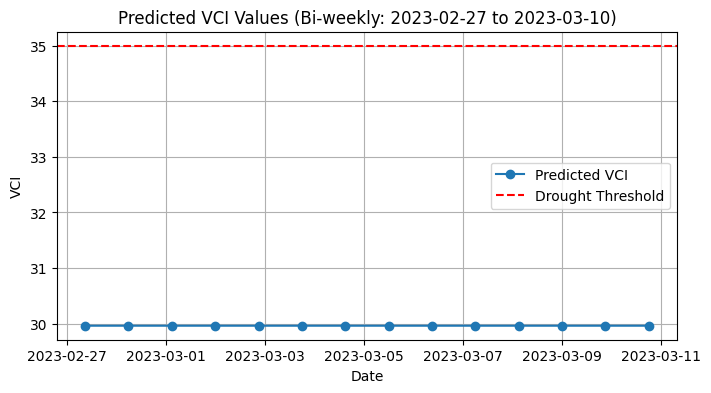

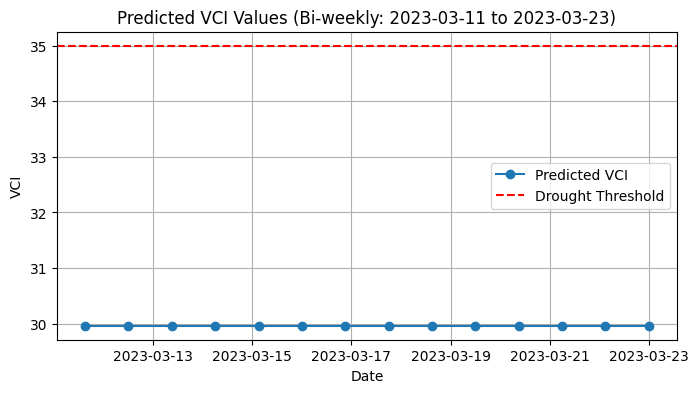

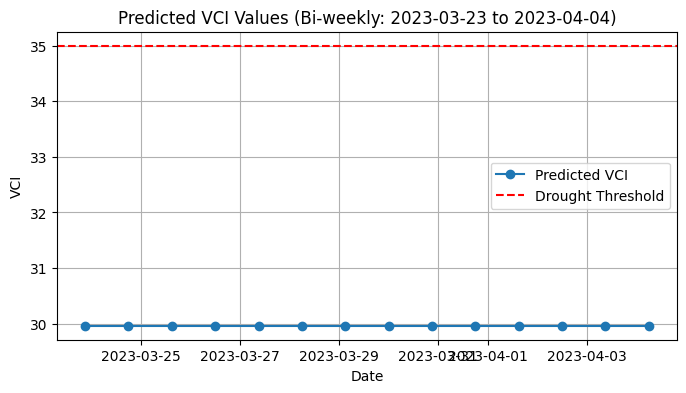

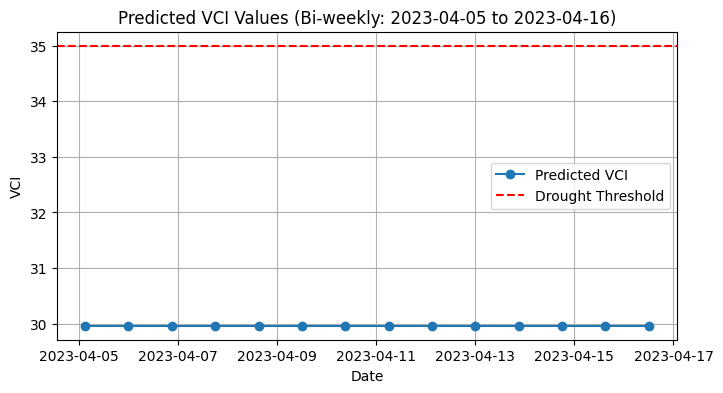

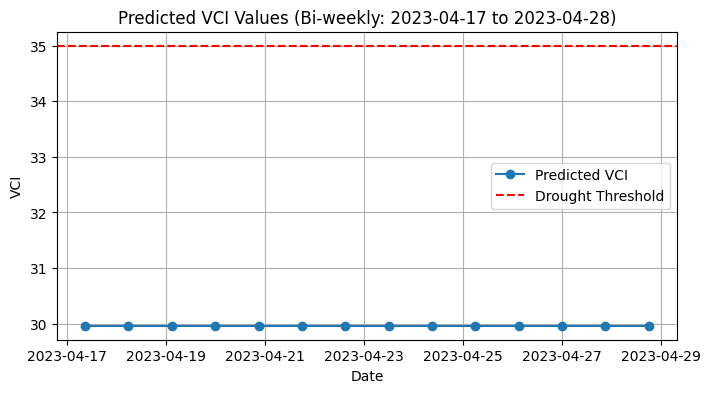

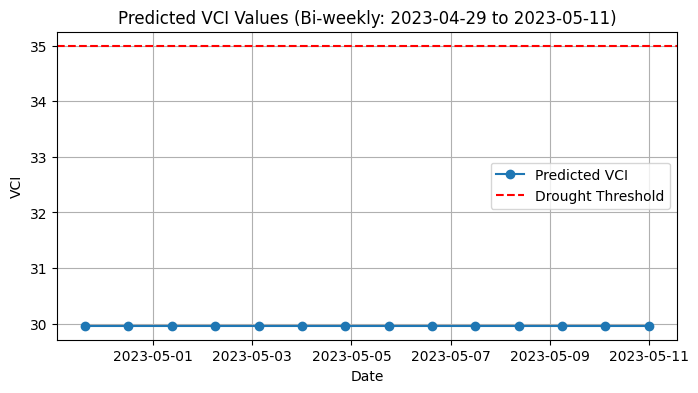

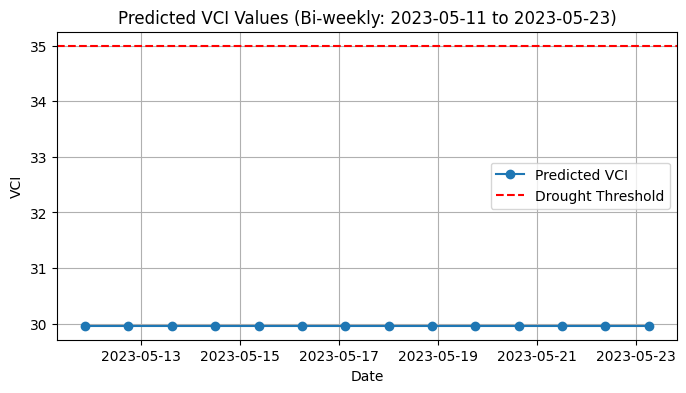

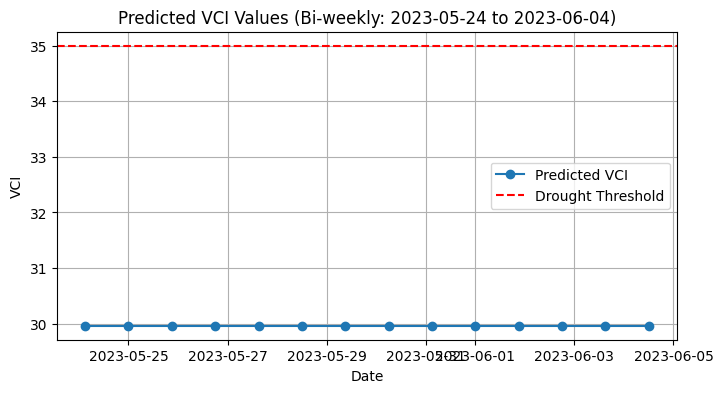

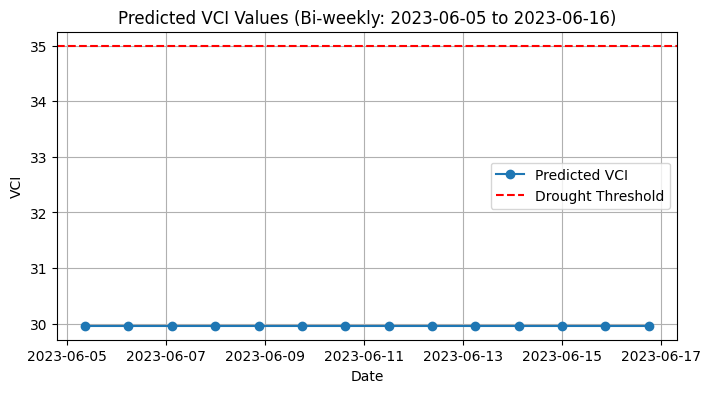

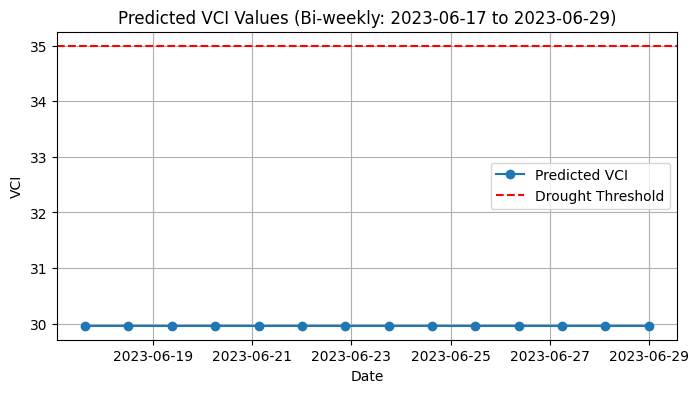

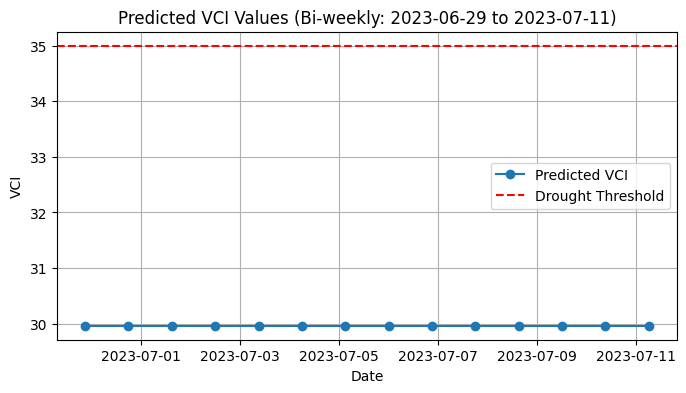

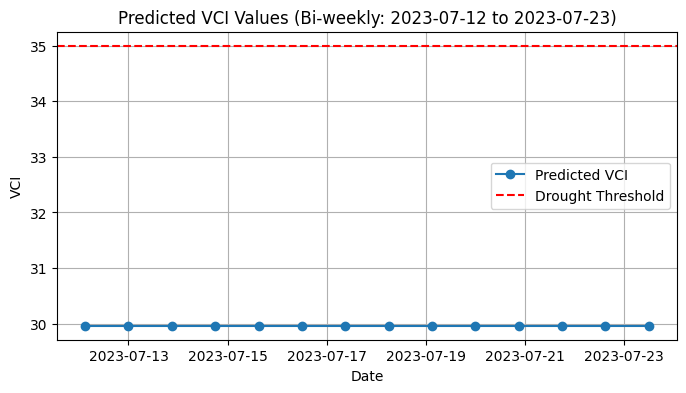

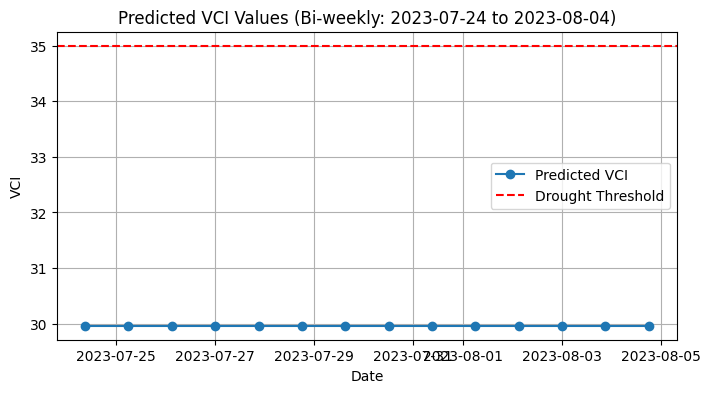

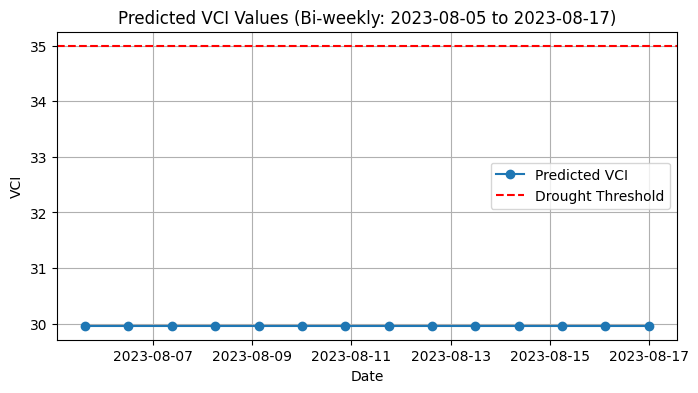

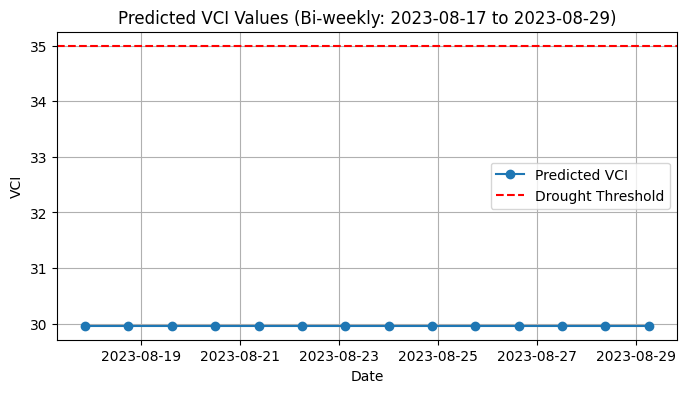

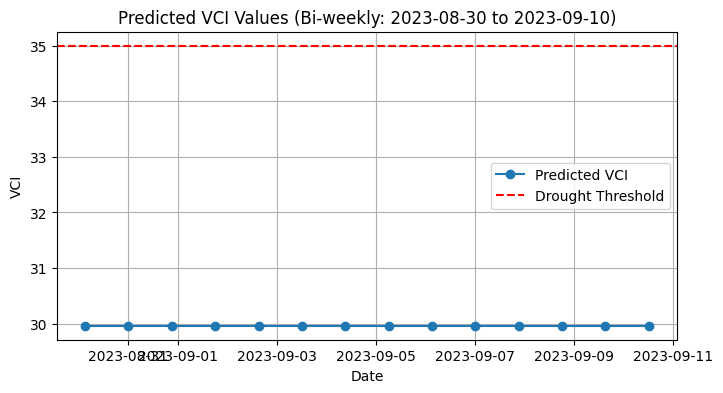

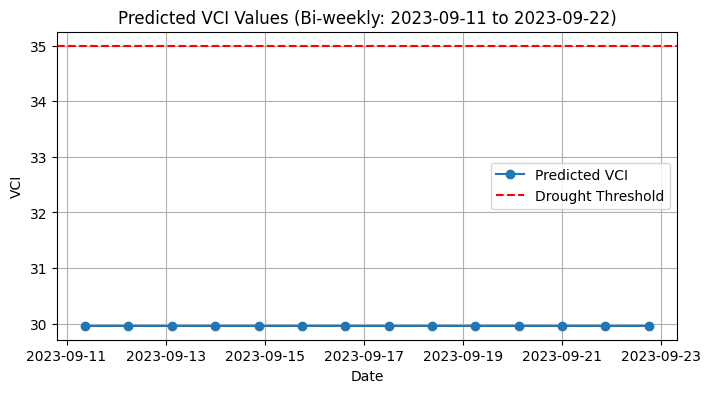

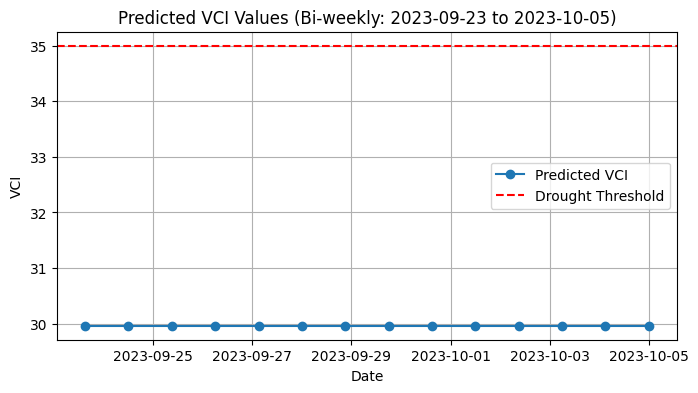

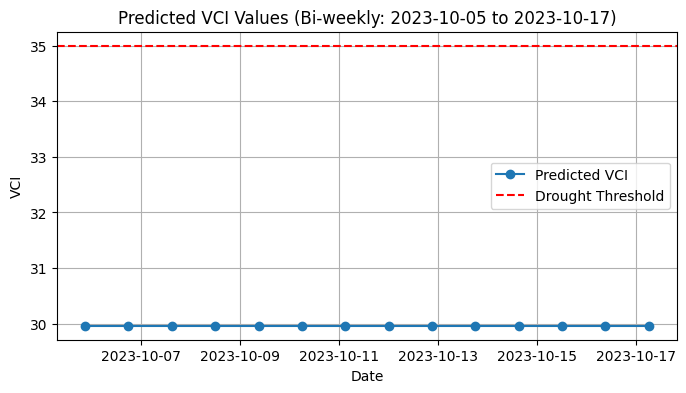

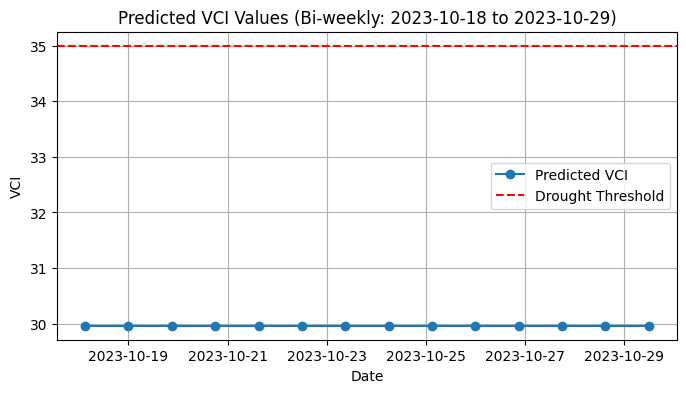

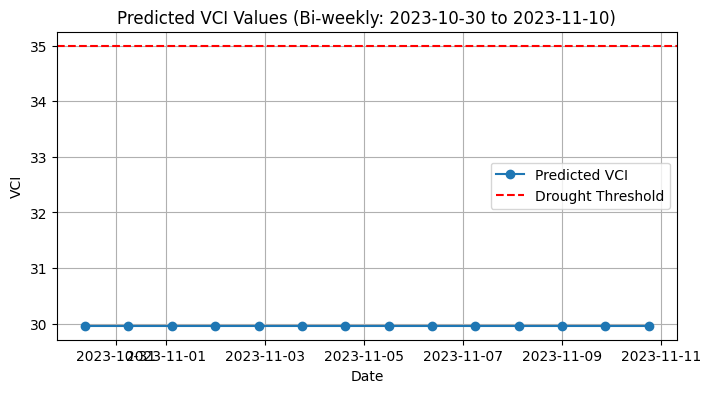

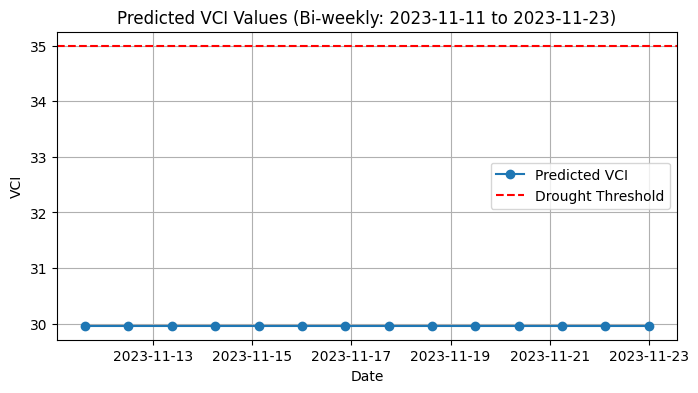

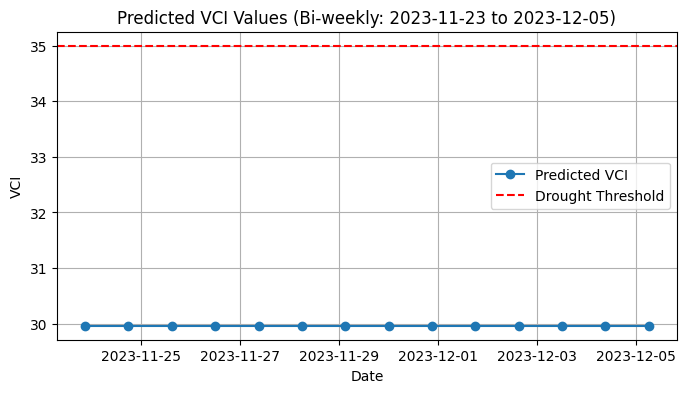

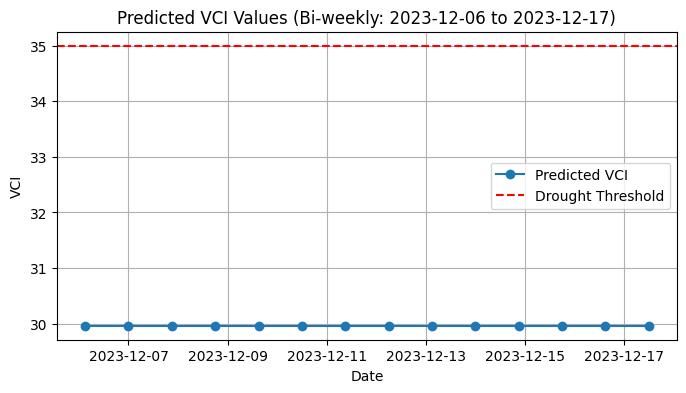

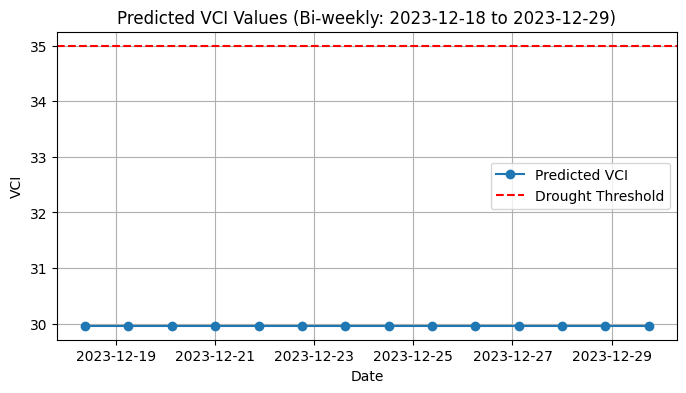

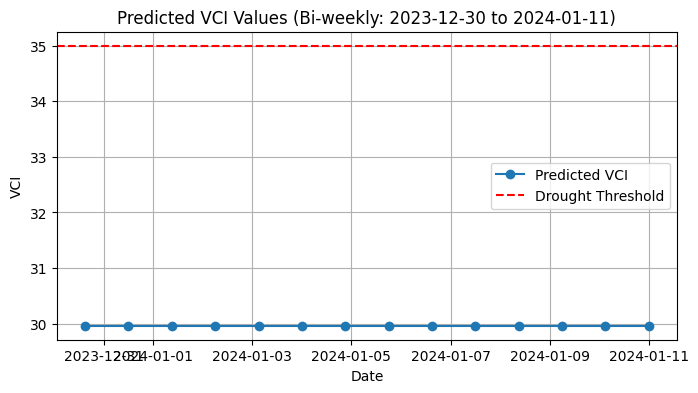

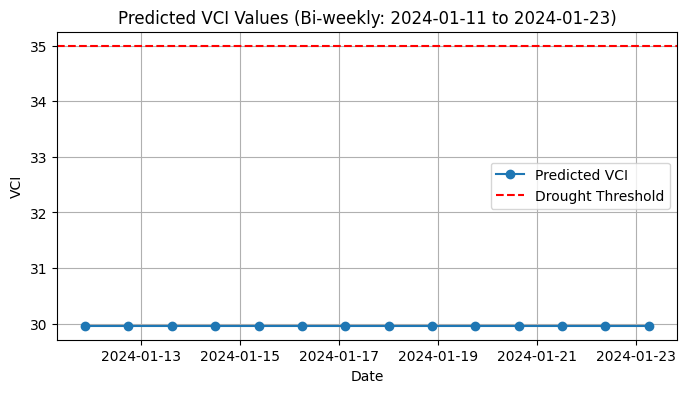

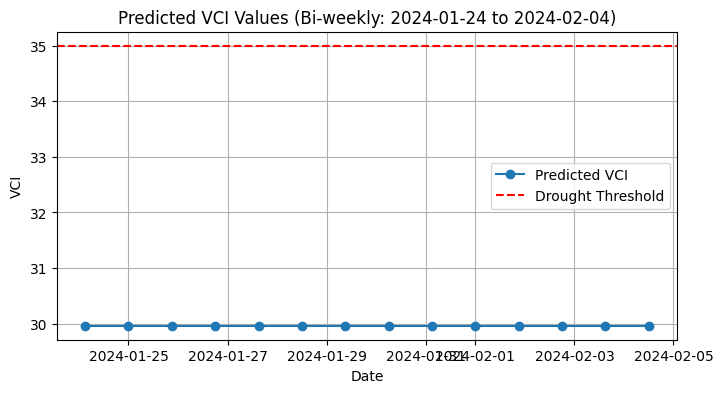

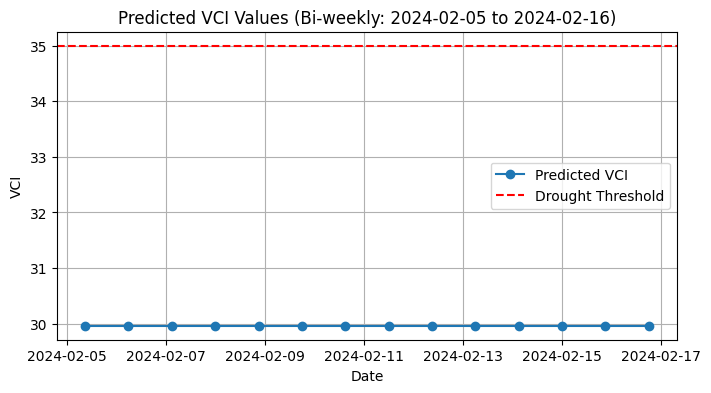

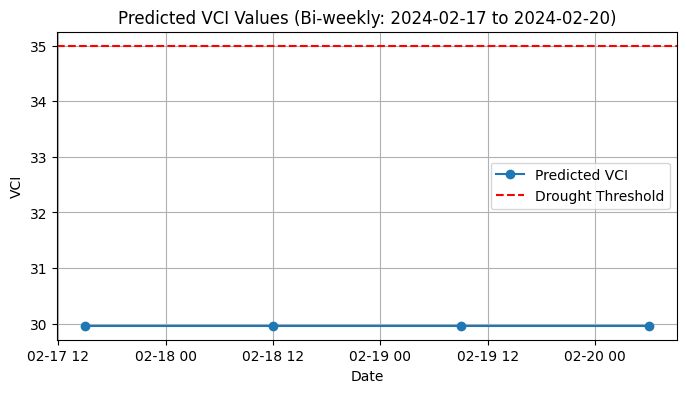

Saving UG.cpg to UG (2).cpg
Saving UG.dbf to UG (2).dbf
Saving UG.prj to UG (2).prj
Saving UG.qmd to UG (2).qmd
Saving UG.shp to UG (2).shp
Saving UG.shx to UG (2).shx


In [ ]:
# Import the necessary libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from folium import Choropleth
from google.colab import files  # Import files to upload
import tensorflow as tf  # Import TensorFlow
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
from IPython.display import display
import matplotlib.pyplot as plt  # Import for plotting
import os  # Required for os.stat
import glob  # Import the glob module

# Mount Google Drive
drive.mount('/content/drive')

# 1. Data Loading and Preprocessing
folder_path = "/content/drive/My Drive/drought_prediction_project/vci"
all_files = glob.glob(folder_path + "/*.csv")
df_list = []

for file in all_files:
    if os.stat(file).st_size > 0:
        try:
            df = pd.read_csv(file)
            df_list.append(df)
        except pd.errors.EmptyDataError:
            print(f"Skipping empty file: {file}")
    else:
        print(f"Skipping empty file: {file}")

df = pd.concat(df_list, ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date')

# Normalize VCI values (0-1)
scaler = MinMaxScaler(feature_range=(0, 1))
df['VCI_Scaled'] = scaler.fit_transform(df[['VCI']])

# Convert to supervised learning format
def create_sequences(data, time_steps=12):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps])
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

time_steps = 12
X, y = create_sequences(df['VCI_Scaled'].values, time_steps)

split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# 2. LSTM Model Definition and Training
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, activation='relu', return_sequences=True, input_shape=(time_steps, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, activation='relu', return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model (if not already trained)
# history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))


# 3. Future Predictions (Bi-weekly - 0.875)
future_steps = 24  # Total prediction period (1 year) - can adjust as needed
biweekly_interval = 0.875  # 0.875 days for bi-weekly prediction #**Your desired interval**

# Assuming your data is at a 16-day frequency, adjust num_predictions:
num_predictions = future_steps * (16 / biweekly_interval)
num_predictions = int(num_predictions)  # Ensure it's an integer

all_predictions = []
current_sequence = X_test[-1]

for _ in range(num_predictions):
    pred = model.predict(current_sequence.reshape(1, time_steps, 1))[0][0]
    all_predictions.append(pred)
    current_sequence = np.roll(current_sequence, -1)
    current_sequence[-1] = pred

future_predictions = scaler.inverse_transform(np.array(all_predictions).reshape(-1, 1))

# Create future dates, accounting for the bi-weekly interval:
future_dates = pd.date_range(start=df['Date'].iloc[-1], periods=num_predictions + 1, freq=f'{biweekly_interval}D')[1:]


# ... (Rest of the code for plotting and maps - adjust accordingly) ...
# --- Plotting Predictions ---

# 1. Plot for all predictions (1 year)
plt.figure(figsize=(12, 6))
plt.plot(future_dates, all_predictions, label='Predicted VCI', marker='o', linestyle='-')
plt.axhline(y=35, color='r', linestyle='--', label='Drought Threshold')
plt.xlabel('Date')
plt.ylabel('VCI')
plt.title('Predicted VCI Values (1 Year)')
plt.legend()
plt.grid(True)
plt.show()

# 2. Bi-weekly plots within the 1-year prediction
biweekly_interval = 14  # 14 days for bi-weekly plots

for i in range(0, len(all_predictions), biweekly_interval):
    # Get data for the current bi-weekly period
    start_index = i
    end_index = min(i + biweekly_interval, len(all_predictions))
    current_dates = future_dates[start_index:end_index]
    current_vci = all_predictions[start_index:end_index]

    # Create bi-weekly plot
    plt.figure(figsize=(8, 4))  # Adjust figure size as needed
    plt.plot(current_dates, current_vci, label='Predicted VCI', marker='o', linestyle='-')
    plt.axhline(y=35, color='r', linestyle='--', label='Drought Threshold')
    plt.xlabel('Date')
    plt.ylabel('VCI')
    plt.title(f'Predicted VCI Values (Bi-weekly: {current_dates[0].strftime("%Y-%m-%d")} to {current_dates[-1].strftime("%Y-%m-%d")})')
    plt.legend()
    plt.grid(True)
    plt.show()



# 4. GeoDataFrame and Choropleth Maps (Biweekly)
# Upload the shapefile
uploaded = files.upload()
uganda = gpd.read_file("UG.shp")

# Biweekly interval (14 days)
biweekly_interval = 14

# Create a list to store the generated maps
maps = []

# Function to classify drought severity
def classify_drought(vci):
    if vci < 35:
        return "Severe Drought"
    elif 35 <= vci < 50:
        return "Moderate Drought"
    else:
        return "No Drought"


# Iterate through the predictions in biweekly intervals
for i in range(0, len(all_predictions), biweekly_interval):
    # Get the VCI predictions for the current biweekly interval
    current_vci = all_predictions[i : i + biweekly_interval]

    # Assign VCI values to the GeoDataFrame for the current interval
    uganda['VCI'] = current_vci[:len(uganda)].astype(float)

    # Categorize drought severity for the current interval
    uganda['Drought_Level'] = uganda['VCI'].apply(classify_drought)

    # Create the Choropleth map for the current interval
    m = folium.Map(location=[1.3733, 32.2903], zoom_start=6)

    choropleth = Choropleth(
        geo_data=uganda,
        name="Drought Map",
        data=uganda,
        columns=["Drought_Level", "VCI"],
        key_on="feature.properties.Drought_Level",
        fill_color="YlOrRd",
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name="VCI Drought Levels"
    ).add_to(m)

    # Add the date of the biweekly interval to the map title
    date_range = (
        future_dates[i].strftime('%Y-%m-%d')
        + " to "
        + future_dates[min(i + biweekly_interval - 1, len(future_dates) - 1)].strftime('%Y-%m-%d')
    )
    choropleth.geojson.add_child(folium.Popup(date_range))
    m.add_child(folium.LatLngPopup())

    # Append the map to the list of maps
    maps.append(m)

# Save all maps as HTML files (optional)
for i, map_obj in enumerate(maps):
    map_obj.save(f"uganda_drought_map_{i}.html")

# Display all the maps (in Colab, they'll be shown one after another)
for map_obj in maps:
    display(map_obj)